In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
os.chdir('/home/sambeet/data/dsg/')

In [25]:
trade = pd.read_csv('trade_recfeats.csv')
test = pd.read_csv('test_recfeats.csv')

In [46]:
trade.head()

,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest,predCustomerInterest,Sector,Subsector,CustomerRegion,...,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,MaturityPeriod
0,0,16471,0,2016,1,False,0.329668,0,24,1,...,2,1,0,11,7,247,5,6.311735,0,5
1,0,16471,0,2016,6,False,0.330347,0,24,1,...,2,1,0,11,7,247,5,6.311735,0,5
2,0,16471,0,2016,20,False,0.330303,0,24,1,...,2,1,0,11,7,247,5,6.311735,0,5
3,0,16471,0,2016,27,False,0.329193,0,24,1,...,2,1,0,11,7,247,5,6.311735,0,5
4,0,16471,0,2016,46,False,0.330132,0,24,1,...,2,1,0,11,7,247,5,6.311735,0,5


In [27]:
customer = pd.read_csv('Customer.csv')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
categorical_columns = ['Sector','Subsector','CustomerRegion','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(customer[col].astype(str))
    customer[col] = encoder.transform(customer[col].astype(str))
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
bond = bond.rename({'Region':'BondRegion'},axis=1)
categorical_columns = ['Seniority','Currency','ActivityGroup','BondRegion','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(bond[col].astype(str))
    bond[col] = encoder.transform(bond[col].astype(str))

Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [28]:
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
trade = trade.merge(bond,on=['IsinIdx'],how='left')
trade['MaturityPeriod'] = ((trade['ActualMaturityDateKey'] - trade['IssueDateKey'])/365.).dt.days
trade['IssuedAmount'] = np.log1p(trade.IssuedAmount/1000000)
trade.drop(['ActualMaturityDateKey','IssueDateKey'],axis=1,inplace=True)

In [29]:
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')
test['MaturityPeriod'] = ((test['ActualMaturityDateKey'] - test['IssueDateKey'])/365.).dt.days
test['IssuedAmount'] = np.log1p(test.IssuedAmount/1000000)
test.drop(['ActualMaturityDateKey','IssueDateKey'],axis=1,inplace=True)
gc.collect()

485

In [30]:
test['predCustomerInterest'] = (test.CustomerInterest_1 + test.CustomerInterest_2 + test.CustomerInterest_3 + test.CustomerInterest_4 + test.CustomerInterest_5)/5.

In [31]:
test.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,CustomerInterest_1,...,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,MaturityPeriod,predCustomerInterest
0,a1e0d80784,2018-04-23,1856,13323,0,NaN,2018,4,17,0.344367,...,4,96,9,4,225,7,6.111467,0,8,0.350722
1,c2cc6cc2a8,2018-04-23,1856,9230,0,NaN,2018,4,17,0.355686,...,4,87,7,7,194,10,5.993961,0,10,0.351610
2,a8e94f6344,2018-04-23,1780,9157,0,NaN,2018,4,17,0.342609,...,22,83,1,9,81,2,5.707110,1,30,0.335508
3,758bae1e35,2018-04-23,2129,9131,0,NaN,2018,4,17,0.324047,...,22,83,1,9,81,7,8.294300,0,10,0.324298
4,02ab378ee8,2018-04-23,1758,7151,0,NaN,2018,4,17,0.313981,...,24,79,14,12,92,10,5.707110,0,9,0.306834


In [32]:
float_type = ['IssuedAmount','predCustomerInterest']
for col in list(trade.columns):
    if col in float_type:
        trade[col] = pd.to_numeric(trade[col],downcast='float')
    else:
        trade[col] = pd.to_numeric(trade[col],downcast='integer')
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30171186 entries, 0 to 30171185
Data columns (total 26 columns):
CustomerIdx             int16
IsinIdx                 int16
BuySell                 int8
year                    int16
weekofyear              int8
CustomerInterest        bool
predCustomerInterest    float32
Sector                  int8
Subsector               int8
CustomerRegion          int8
Country                 int8
TickerIdx               int16
Seniority               int8
Currency                int8
ActivityGroup           int8
BondRegion              int8
Activity                int8
RiskCaptain             int8
Owner                   int8
CompositeRating         int8
IndustrySector          int8
IndustrySubgroup        int16
MarketIssue             int8
IssuedAmount            float32
CouponType              int8
MaturityPeriod          int16
dtypes: bool(1), float32(2), int16(6), int8(17)
memory usage: 1.3 GB


In [38]:
categorical_holdings = ['BuySell','year','CustomerRegion']
predictors_holdings = ['BuySell','year','CustomerRegion','predCustomerInterest','IssuedAmount','MaturityPeriod']
#predictors_holdings.remove('CustomerInterest')
#predictors_holdings.remove('CustomerIdx')
#predictors_holdings.remove('IsinIdx')
target_holdings = 'CustomerInterest'

In [39]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 31,
#    'max_depth': 3,
    'learning_rate' : 0.1,
#    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
#    'scale_pos_weight' : 10
}

In [40]:
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
kf = KFold(n_splits=5,shuffle=True,random_state=37)
kf.get_n_splits(trade)
for i, (train_index, test_index) in zip(range(1,6),kf.split(trade)):
    X_train = trade.loc[train_index,predictors_holdings].values
    X_test = trade.loc[test_index,predictors_holdings].values
    y_train = trade.loc[train_index,target_holdings].values
    y_test = trade.loc[test_index,target_holdings].values
    X_train = lgb.Dataset(X_train,y_train,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
    X_test = lgb.Dataset(X_test,y_test,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
    gc.collect()
    print 'Starting training on fold:',i
    model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_test],valid_names=['valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=100)
    test['CustomerInterest_' + str(i)] = model.predict(test.loc[:,predictors_holdings].values)

Starting training on fold: 1
Training until validation scores don't improve for 50 rounds.
[50]	valid's auc: 0.833572
[100]	valid's auc: 0.834194
[150]	valid's auc: 0.834378
[200]	valid's auc: 0.834494
[250]	valid's auc: 0.834583
[300]	valid's auc: 0.834634
[350]	valid's auc: 0.834659
[400]	valid's auc: 0.83469
[450]	valid's auc: 0.834707
[500]	valid's auc: 0.83474
[550]	valid's auc: 0.83477
[600]	valid's auc: 0.834783
[650]	valid's auc: 0.834803
[700]	valid's auc: 0.834829
[750]	valid's auc: 0.834844
[800]	valid's auc: 0.834856
[850]	valid's auc: 0.834873
[900]	valid's auc: 0.834888
[950]	valid's auc: 0.834897
[1000]	valid's auc: 0.834904
[1050]	valid's auc: 0.834914
[1100]	valid's auc: 0.83492
Early stopping, best iteration is:
[1090]	valid's auc: 0.834922
Starting training on fold: 2
Training until validation scores don't improve for 50 rounds.
[50]	valid's auc: 0.833978
[100]	valid's auc: 0.834593
[150]	valid's auc: 0.834751
[200]	valid's auc: 0.83486
[250]	valid's auc: 0.834949
[3

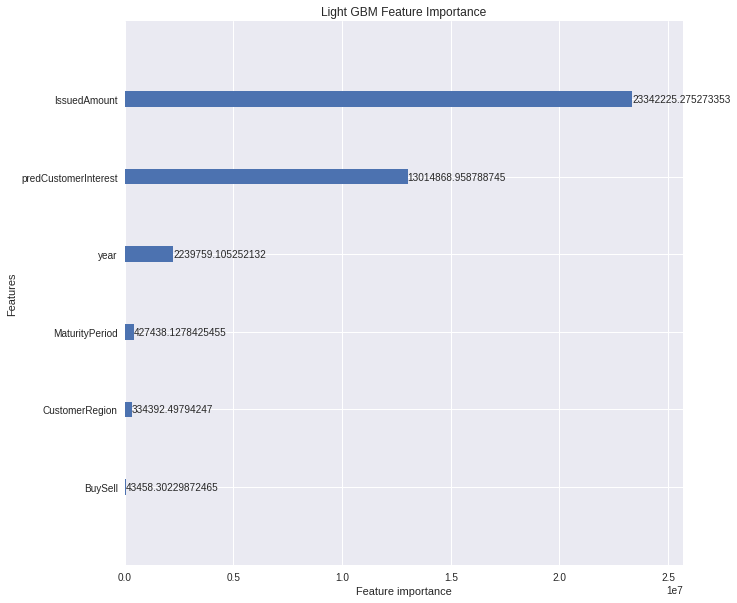

In [45]:
lgb.plot_importance(model,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

In [42]:
test['CustomerInterest_1'] = test.CustomerInterest_1.rank(pct=True)
test['CustomerInterest_2'] = test.CustomerInterest_2.rank(pct=True)
test['CustomerInterest_3'] = test.CustomerInterest_3.rank(pct=True)
test['CustomerInterest_4'] = test.CustomerInterest_4.rank(pct=True)
test['CustomerInterest_5'] = test.CustomerInterest_5.rank(pct=True)

In [43]:
test['CustomerInterest'] = (test.CustomerInterest_1 + test.CustomerInterest_2 + test.CustomerInterest_3 + test.CustomerInterest_4 + test.CustomerInterest_5)/5.

In [44]:
test[['PredictionIdx','CustomerInterest']].to_csv('sub_sam_lgb_1.csv',index=False)

import catboost as cb
cat_features_index = [0,1]

'''
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)
'''
#With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=255,depth=3, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.01)
clf.fit(trade.loc[train_index,predictors],trade.loc[train_index,target], cat_features= cat_features_index,
       eval_set=(trade.loc[valid_index,predictors],trade.loc[valid_index,target]),plot=True)

#Create valid
filtered = trade[(trade.year == 2018) & (trade.weekofyear >= 13) & (trade.CustomerInterest == True)].reset_index(drop=True)
filtered = filtered.drop_duplicates()
#filtered = filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear']]
filtered_sell = filtered[['CustomerIdx','IsinIdx']].drop_duplicates()
filtered_buy = filtered_sell.copy()
filtered_sell['BuySell'] = 1
filtered_buy['BuySell'] = 0
filtered_valid_1 = pd.concat([filtered_sell,filtered_buy],axis=0)
filtered_valid_1['year'] = 2018.
filtered_valid_1['weekofyear'] = 13
filtered_valid_2 = filtered_valid_1.copy()
filtered_valid_2['weekofyear'] = 14
filtered_valid_3 = filtered_valid_1.copy()
filtered_valid_3['weekofyear'] = 15
filtered_valid_4 = filtered_valid_1.copy()
filtered_valid_4['weekofyear'] = 16
filtered_valid = pd.concat([filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4],axis=0)
del filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4,filtered_buy,filtered_sell
gc.collect()
filtered_valid = filtered_valid.merge(filtered,on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
filtered_valid['CustomerInterest'][filtered_valid.CustomerInterest.isnull()] = 0
filtered_valid.head()

filtered_valid['predCustomerInterest'] = model.predict(filtered_valid.loc[:,predictors].values)
filtered_valid['predCustomerInterest'][filtered_valid.BuySell == 0] = 1 - filtered_valid['predCustomerInterest'][filtered_valid.BuySell == 0]

from sklearn.metrics import roc_auc_score
y_true = filtered_valid.CustomerInterest.astype(int).values
y_scores = filtered_valid.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

In [47]:
trade.columns

Index([u'CustomerIdx', u'IsinIdx', u'BuySell', u'year', u'weekofyear',
       u'CustomerInterest', u'predCustomerInterest', u'Sector', u'Subsector',
       u'CustomerRegion', u'Country', u'TickerIdx', u'Seniority', u'Currency',
       u'ActivityGroup', u'BondRegion', u'Activity', u'RiskCaptain', u'Owner',
       u'CompositeRating', u'IndustrySector', u'IndustrySubgroup',
       u'MarketIssue', u'IssuedAmount', u'CouponType', u'MaturityPeriod'],
      dtype='object')

In [75]:
#trade.groupby('Sector')['CustomerInterest'].agg(['mean','count']).reset_index()
#Sector - Club 0,2,3
#trade.groupby('Subsector')['CustomerInterest'].agg(['mean','count']).reset_index().sort_values(['mean'])
#Subsector - Mean < 4%, > 4% and < 8%,> 8%
#TickerIdx ?
#Currency - Higher than 6 and less than 6
#BondRegion ?
#Owner - < 4%, > 4% and < 8%,> 8%
#MaturityPeriod - > 7%, < 5%
trade.groupby('MaturityPeriod')['CustomerInterest'].agg(['mean','count']).reset_index().sort_values(['mean'])

,MaturityPeriod,mean,count
59,65,0.002265,883
58,64,0.005070,1775
52,55,0.005188,2313
53,57,0.006033,663
56,62,0.010246,488
57,63,0.015828,2843
70,158,0.024390,82
45,45,0.026469,8236
61,90,0.029412,34
66,148,0.030961,1841
